In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# ========================
# Configuration
# ========================
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 7
batch_size = 32
learning_rate = 0.0002
epochs = 30
decay = 1e-3
train_dir = r"C:\Users\user\Desktop\MobileNetV3\DATASET\train"
test_dir = r"C:\Users\user\Desktop\MobileNetV3\DATASET\test"

In [4]:
class BalancedAugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, minority_classes, base_transform, extra_transform):
        self.dataset = dataset
        self.minority_classes = minority_classes
        self.base_transform = base_transform
        self.extra_transform = extra_transform

    def __getitem__(self, index):
        img, label = self.dataset[index]
        if label in self.minority_classes:
            img = self.extra_transform(self.base_transform(img))
        else:
            img = self.base_transform(img)

        return img, label

    def __len__(self):
        return len(self.dataset)



In [5]:
from torch.utils.data import Dataset

class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


In [6]:
# ========================
# Data Augmentation
# ========================
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_validation = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

extra_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomPerspective(distortion_scale=0.4, p=0.7)
])

In [7]:
#Early stopping if validation accuracy doesn't increase after 10 epochs
class EarlyStopping:
    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss):
        score = -val_loss  # Since lower loss is better

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f"⚠️ EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0



In [8]:
# Load dataset from the train directory
full_train_dataset = datasets.ImageFolder(
    root=r"C:\Users\user\Desktop\MobileNetV3\DATASET\train",
    transform=None
)

# Print total number of training images
print(f"✅ Total training images: {len(full_train_dataset)}")

# Print class names
print(f"📂 Class names: {full_train_dataset.classes}")

# Print number of classes
print(f"🔢 Number of classes: {len(full_train_dataset.classes)}")

✅ Total training images: 31154
📂 Class names: ['1', '2', '3', '4', '5', '6', '7']
🔢 Number of classes: 7


In [9]:
# Load dataset from the test directory
test_dataset = datasets.ImageFolder(
    root=r"C:\Users\user\Desktop\MobileNetV3\DATASET\test",
    transform=transform_test
)

# Print total number of images
print(f"✅ Total test images: {len(test_dataset)}")

# Print class names
print(f"📂 Class names: {test_dataset.classes}")

# Print number of classes
print(f"🔢 Number of classes: {len(test_dataset.classes)}")

✅ Total test images: 3068
📂 Class names: ['1', '2', '3', '4', '5', '6', '7']
🔢 Number of classes: 7


In [10]:
from collections import Counter
from torch.utils.data import Subset

# Get targets
targets = [label for _, label in full_train_dataset]
class_counts = Counter(targets)

# Total samples and weights
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[i] for i in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("📊 Class Weights:", class_weights)


📊 Class Weights: tensor([ 6.1291,  6.1327, 24.6472,  6.5285,  6.1789,  6.1194,  6.4608])


In [12]:
# ========================
# Model Setup
# ========================
model = models.mobilenet_v3_large(pretrained=True)
# model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
# in_features = model.classifier[3].in_features

model.classifier = nn.Sequential(
    nn.Linear(960, 1024),  # You can tune 1024 to any reasonable hidden size
    nn.ReLU(),
    nn.Dropout(p=0.5),             # Dropout to prevent overfitting
    nn.Linear(1024, num_classes)
)

model = model.to(device)

# ========================
# Loss, Optimizer, Scheduler
# ========================
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [13]:
# Split train into train/val
# val_size = int(0.2 * len(full_train_dataset))
# train_size = len(full_train_dataset) - val_size
# train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import WeightedRandomSampler

targets = [label for _, label in full_train_dataset]
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    train_dataset = torch.utils.data.Subset(full_train_dataset, train_idx)
    val_dataset = torch.utils.data.Subset(full_train_dataset, val_idx)
    


targets = [label for _, label in train_dataset]
# class_sample_counts = Counter(targets)
# class_weights = 1. / torch.tensor([class_sample_counts[t] for t in targets], dtype=torch.float)
sample_weights = torch.tensor([class_weights[t] for t in targets])

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


# Wrap only the train_dataset with augmentation
minority_classes = [2]  # surprise=0, fear=1, disgust=2, angry=5 (ImageFolder assigns 0-based)
train_dataset = BalancedAugmentedDataset(train_dataset, minority_classes,transform_train, extra_transform)
val_dataset = SubsetWithTransform(val_dataset, transform_validation)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = full_train_dataset.classes

In [14]:
from tqdm import tqdm


def train():
    print("🚀 Training started...\n")
    best_acc = 0.0
    best_model_path = "my_best_model.pth"
    early_stopping = EarlyStopping(patience=10, verbose=True)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        print(f"\nEpoch [{epoch+1}/{epochs}]")
        progress_bar = tqdm(train_loader, desc="Training", leave=False)

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())

        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)  # Compute val loss
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100 * val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        print(f"✅ Epoch [{epoch+1}/{epochs}] - "
              f"Loss: {total_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Acc: {val_acc:.2f}%, Val Loss: {avg_val_loss:.4f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), best_model_path)

        #  Pass validation loss to scheduler
        scheduler.step(avg_val_loss)
        
        #  Check for early stopping
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print("⏹️ Early stopping triggered. Stopping training.")
            break


In [15]:
# Label mapping
label_mapping = {
    1: 'surprise',
    2: 'fear',
    3: 'disgust',
    4: 'happy',
    5: 'sad',
    6: 'angry',
    7: 'neutral'
}

# ========================
# Evaluation
# ========================
def evaluate():
    model.load_state_dict(torch.load("my_best_model.pth"))
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Map numeric labels to emotion names
    mapped_preds = [label_mapping[pred + 1] for pred in all_preds]
    mapped_labels = [label_mapping[label + 1] for label in all_labels]

    emotion_names = list(label_mapping.values())

    print("\nClassification Report:\n")
    print(classification_report(mapped_labels, mapped_preds, target_names=emotion_names))

    # Confusion Matrix
    cm = confusion_matrix(mapped_labels, mapped_preds, labels=emotion_names)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_names, yticklabels=emotion_names, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [ ]:
# =============
# Run Training
# =============
train()


Classification Report:

              precision    recall  f1-score   support

    surprise       0.59      0.22      0.32       162
        fear       0.05      0.59      0.09       160
     disgust       0.68      0.43      0.53        74
       happy       0.86      0.34      0.49      1185
         sad       0.70      0.27      0.39       680
       angry       0.73      0.26      0.38       478
     neutral       0.51      0.27      0.35       329

    accuracy                           0.31      3068
   macro avg       0.59      0.34      0.37      3068
weighted avg       0.70      0.31      0.41      3068



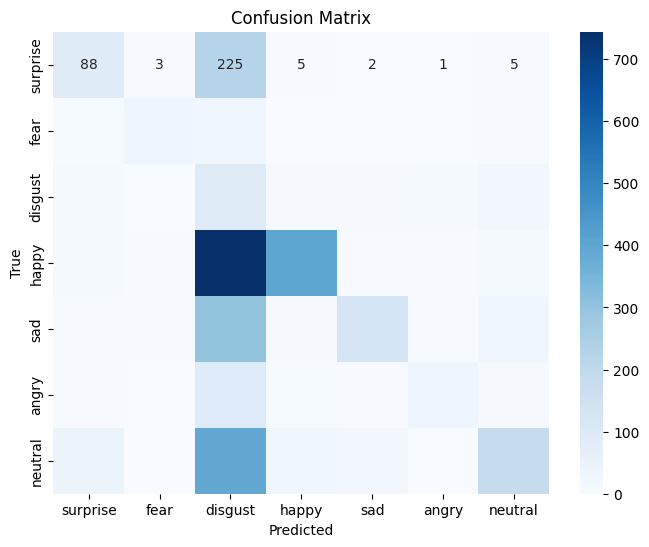

In [16]:
# ===============
# Run Evaluation
# ===============
evaluate()

In [ ]:
# =================
# Save Final Model
# =================
torch.save(model.state_dict(), "mobilenetv3_emotion_model.pth")

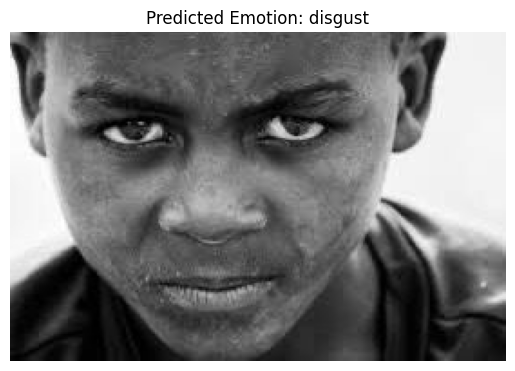

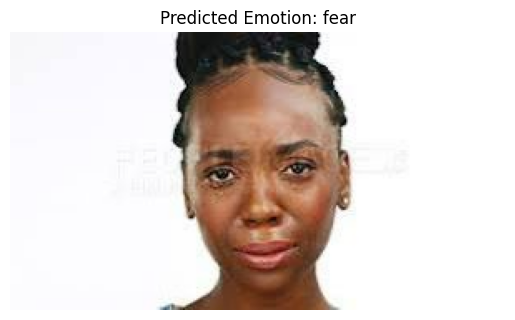

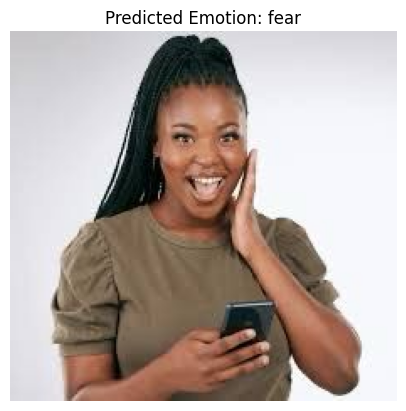

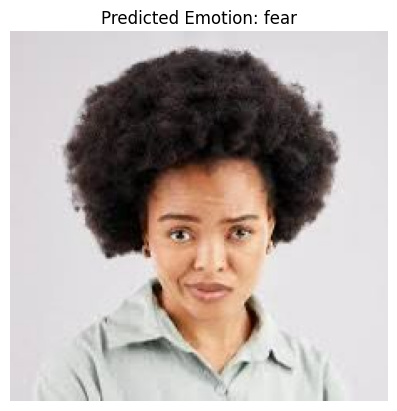

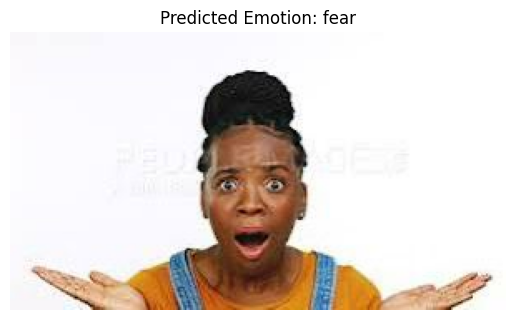

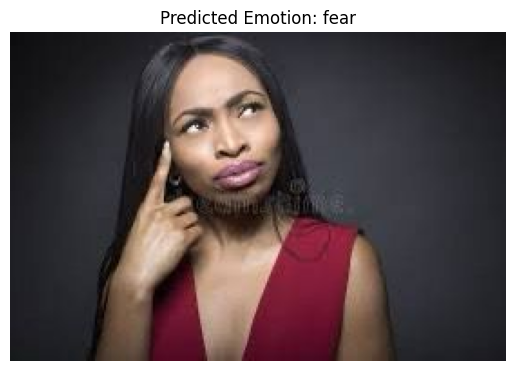

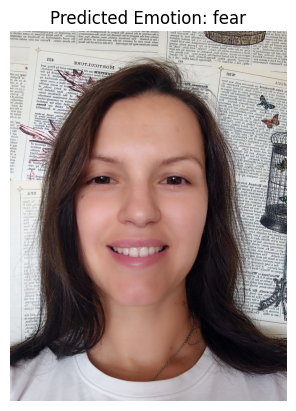

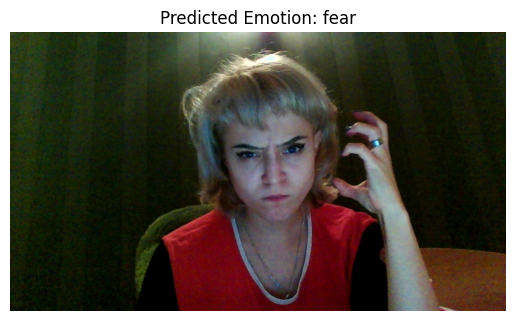

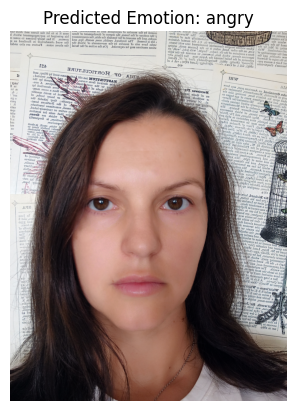

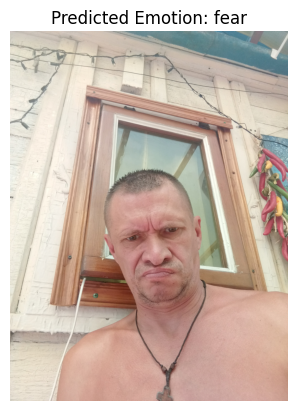

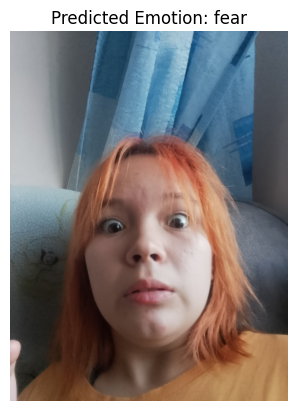

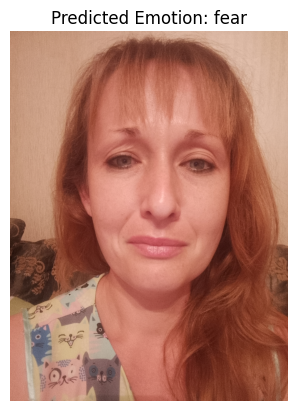

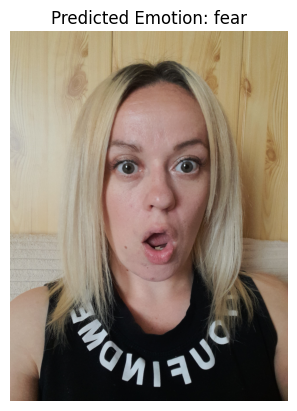

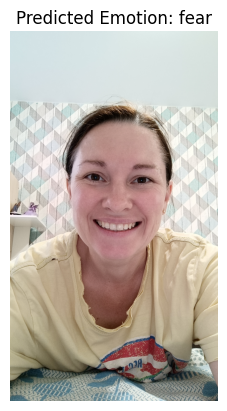

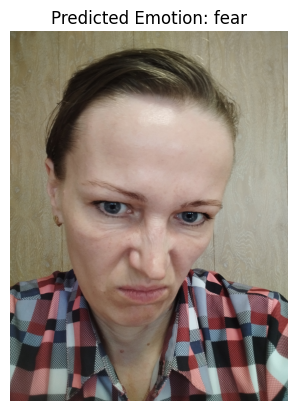

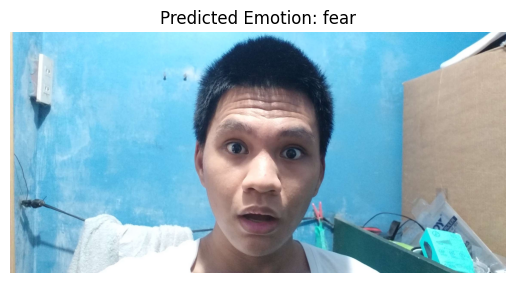

In [21]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define label mapping
label_mapping = {
    1: "angry",
    2: "disgust",
    3: "fear",
    4: "happy",
    5: "neutral",
    6: "sad",
    7: "surprise"
}


# Load model architecture and weights
model.classifier[3] = nn.Linear(in_features=1024, out_features=7)
model.load_state_dict(torch.load("my_best_model.pth", map_location=device))
model.to(device)
model.eval()

# Image transform (same as validation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Predict function
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        emotion_label = label_mapping[predicted.item() + 1]
    
    return emotion_label, image

# Predict images in a folder
folder_path = "Test"
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

for file in image_files:
    file_path = os.path.join(folder_path, file)
    emotion, image = predict_image(file_path)
    
    plt.imshow(image)
    plt.title(f"Predicted Emotion: {emotion}")
    plt.axis('off')
    plt.show()
